In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import f
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

#Import Data
file_path = 'Dry_Bean_Dataset.xlsx'
df = pd.read_excel(file_path)

#Remove the Duplicates
df_cleaned = df.drop_duplicates()

#clean data
output_filename = 'Dry_Bean_Dataset_Cleaned.csv'
df_cleaned.to_csv(output_filename, index=False)


Dataset Shape: (13543, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13543 entries, 0 to 13542
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13543 non-null  int64  
 1   Perimeter        13543 non-null  float64
 2   MajorAxisLength  13543 non-null  float64
 3   MinorAxisLength  13543 non-null  float64
 4   AspectRation     13543 non-null  float64
 5   Eccentricity     13543 non-null  float64
 6   ConvexArea       13543 non-null  int64  
 7   EquivDiameter    13543 non-null  float64
 8   Extent           13543 non-null  float64
 9   Solidity         13543 non-null  float64
 10  roundness        13543 non-null  float64
 11  Compactness      13543 non-null  float64
 12  ShapeFactor1     13543 non-null  float64
 13  ShapeFactor2     13543 non-null  float64
 14  ShapeFactor3     13543 non-null  float64
 15  ShapeFactor4     13543 non-null  float64
 16  Class            13543 non-null

/tmp/ipykernel_4656/3381831932.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Class', data=df_cleaned, palette='viridis',


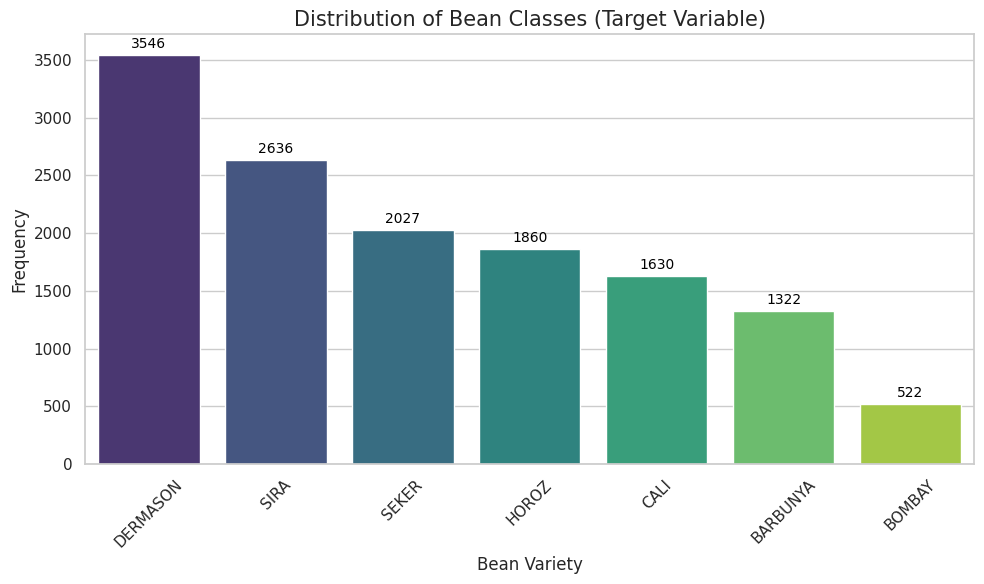

In [17]:
#1)EDA

#dataset shape
print("Dataset Shape:", df.shape)
print(df.info())

#set style for the plots
sns.set(style="whitegrid")

#Class distribution analysis 
plt.figure(figsize=(10, 6))
# Create a countplot sorted by frequency
ax = sns.countplot(x='Class', data=df_cleaned, palette='viridis', 
                   order=df_cleaned['Class'].value_counts().index)

plt.title('Distribution of Bean Classes (Target Variable)', fontsize=15)
plt.xlabel('Bean Variety', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)

# Add data labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, 
                color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.savefig('./1)EDA/EDA_Class_Distribution.png')
plt.show()


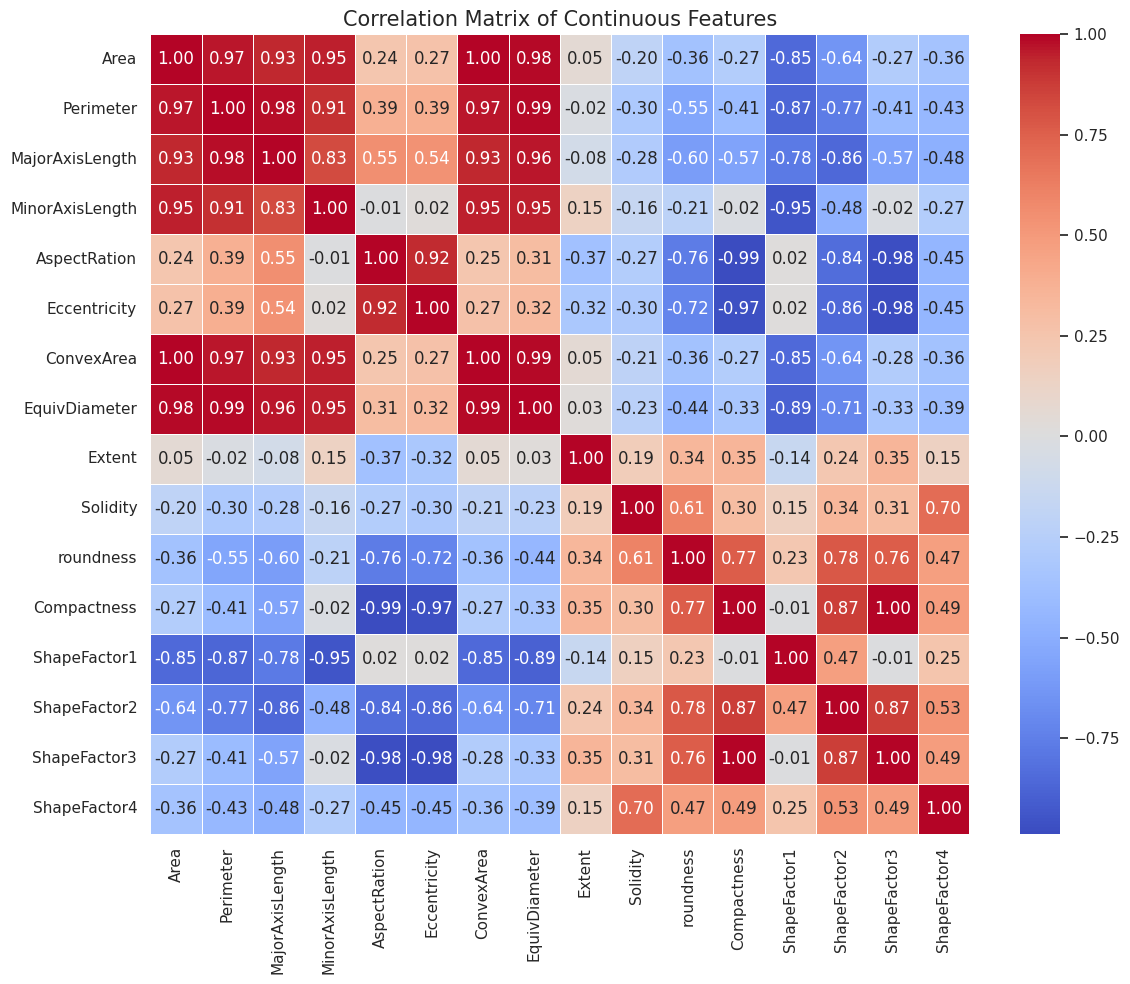

In [18]:
#Correlation Matrix
# Objective: Identify multicollinearity among continuous variables.

#Select only numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Continuous Features', fontsize=15)
plt.tight_layout()
plt.savefig('./1)EDA/EDA_Correlation_Matrix.png')
plt.show()



/tmp/ipykernel_4656/1929878619.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Area', data=df, ax=axes[0], palette='Set2')
/tmp/ipykernel_4656/1929878619.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='ShapeFactor1', data=df, ax=axes[1], palette='Set2')


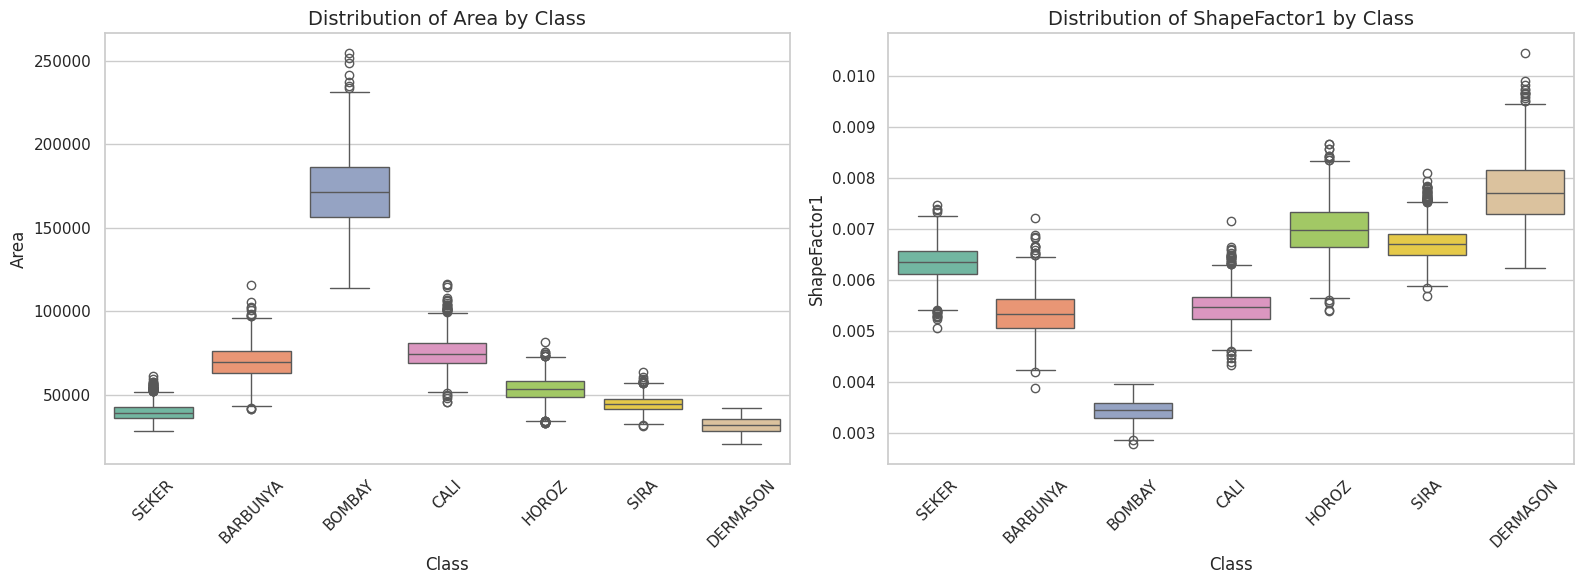

In [19]:
#Feature distributions by class (Boxplots)
# Objective: Observe how features vary across different classes.

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for 'Area' (size)
sns.boxplot(x='Class', y='Area', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Distribution of Area by Class', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Boxplot for 'ShapeFactor1' (shape)
sns.boxplot(x='Class', y='ShapeFactor1', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Distribution of ShapeFactor1 by Class', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('./1)EDA/EDA_Boxplots.png')
plt.show()

In [8]:
#2)INFERENCES ABOUT MEAN VECTOR

#Create a custom function for Hotelling's T-squared Test
def hotelling_t2_two_sample(df, group_col, class1, class2):
    """
    Performs a Two-Sample Hotelling's T-squared Test.
    
    This function tests whether the mean vectors of two independent multivariate 
    groups are significantly different.
    
    Hypotheses:
    - H0: The mean vectors of the two groups are equal (mu1 = mu2).
    - H1: The mean vectors of the two groups are different (mu1 != mu2).
    
    Assumptions:
    - Independent samples.
    - Multivariate normal distribution (approximate for large N).
    - Homogeneity of covariance matrices (Homoscedasticity).
    """
    
    # Data selection
    # Select continuous variables for the two specified groups
    data1 = df[df[group_col] == class1].select_dtypes(include=[np.number])
    data2 = df[df[group_col] == class2].select_dtypes(include=[np.number])
    
    # Sample sizes  and Num. of Variables (p)
    n1 = len(data1)
    n2 = len(data2)
    
    # Number of dimensions/features (e.g., 16 for Dry Bean)
    p = data1.shape[1]
    
    # Calculate mean vectors
    mean_vec1 = data1.mean().values
    mean_vec2 = data2.mean().values
    
    # Calculate covariance matrices (S)
    S1 = data1.cov()
    S2 = data2.cov()
    
    # Calculate pooled covariance matrix (Sp)
    # We pool the variances under the assumption that population covariance matrices are equal.
    # Formula: Sp = [(n1-1)S1 + (n2-1)S2] / (n1 + n2 - 2)
    Sp = ((n1 - 1) * S1 + (n2 - 1) * S2) / (n1 + n2 - 2)
    
    # Calculate Hotelling's T-squared Statistic (T2)
    # Formula: T2 = (n1*n2)/(n1+n2) * (mean_diff)' * inv(Sp) * (mean_diff)
    diff_mean = mean_vec1 - mean_vec2
    inv_Sp = np.linalg.inv(Sp) # Inverse of Pooled Covariance Matrix
    
    t2_stat = (n1 * n2) / (n1 + n2) * diff_mean.T @ inv_Sp @ diff_mean
    
    # Convert T2 to F-Statistic
    # We convert T2 to an F-distribution to calculate the P-value easier.
    # Transformation Factor = (n1 + n2 - p - 1) / (p * (n1 + n2 - 2))
    factor = (n1 + n2 - p - 1) / (p * (n1 + n2 - 2))
    f_stat = factor * t2_stat
    
    # 8. Calculate P-Value
    # Degrees of Freedom: df1 = p, df2 = n1 + n2 - p - 1
    df1 = p
    df2 = n1 + n2 - p - 1
    p_value = 1 - f.cdf(f_stat, df1, df2)
    
    # Return a dictionary with all results
    return {
        'n1': n1, 'n2': n2, 'p': p,
        't2_stat': t2_stat,
        'f_stat': f_stat,
        'df1': df1, 'df2': df2,
        'p_value': p_value
    }

In [9]:
# Bu comment yapacağımız sunum için kendimize notlar
# We compare 'SEKER' and 'DERMASON' varieties as an example.
result = hotelling_t2_two_sample(df, 'Class', 'SEKER', 'DERMASON')

print("  STAGE 2: Inferences About a Mean Vector (Hotelling's T² Test)")
print(f"Comparison Groups:        'SEKER' vs 'DERMASON'")
print(f"Sample Sizes:             n1 = {result['n1']}, n2 = {result['n2']}")
print(f"Number of Variables (p):  {result['p']}")
print("-" * 66)
print(f"Hotelling's T² Statistic: {result['t2_stat']:.4f}")
print(f"F-Statistic Approximation:{result['f_stat']:.4f}")
print(f"Degrees of Freedom:       df1 = {result['df1']}, df2 = {result['df2']}")
print(f"P-Value:                  {result['p_value']:.10f}")
print("-" * 66)

#Decision Rule
alpha = 0.05
if result['p_value'] < alpha:
    print(f"DECISION: REJECT H0 (p < {alpha})")
    print("INTERPRETATION: There is a statistically significant difference")
    print("between the multivariate mean vectors of 'SEKER' and 'DERMASON'.")
    print("The two bean varieties are distinct in terms of their geometric features.")
else:
    print(f"DECISION: FAIL TO REJECT H0 (p >= {alpha})")
    print("INTERPRETATION: No statistical difference found between the mean vectors.")
print("==================================================================")

  STAGE 2: Inferences About a Mean Vector (Hotelling's T² Test)
Comparison Groups:        'SEKER' vs 'DERMASON'
Sample Sizes:             n1 = 2027, n2 = 3546
Number of Variables (p):  16
------------------------------------------------------------------
Hotelling's T² Statistic: 31630.4521
F-Statistic Approximation:1971.5804
Degrees of Freedom:       df1 = 16, df2 = 5556
P-Value:                  0.0000000000
------------------------------------------------------------------
DECISION: REJECT H0 (p < 0.05)
INTERPRETATION: There is a statistically significant difference
between the multivariate mean vectors of 'SEKER' and 'DERMASON'.
The two bean varieties are distinct in terms of their geometric features.


In [10]:
#3)Comparisons of Several Multivariate Means (MANOVA)

try:
    df = pd.read_csv('Dry_Bean_Dataset_Cleaned.csv')
    print("Data Loaded Successfully.\n")
except FileNotFoundError:
    print("Error: File not found.")

# Prepare the MANOVA Formula
# MANOVA syntax in statsmodels: 'DepVar1 + DepVar2 + ... ~ IndepVar'
# This string is generated dynamically to prevent the need to manually input all 16 variable names.

# Get all continuous variable names (excluding 'Class')
dependent_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Join them with ' + '
dep_var_string = ' + '.join(dependent_vars)

# Create the final formula: e.g., "Area + Perimeter + ... ~ Class"
formula = f'{dep_var_string} ~ Class'

print(f"MANOVA Formula Generated: \n{formula[:50]}... (truncated)\n")

# Perform MANOVA
manova = MANOVA.from_formula(formula, data=df)
manova_result = manova.mv_test()

# Print and Interpret Results
print("==================================================================")
print("  STAGE 3: Comparisons of Several Multivariate Means (MANOVA)")
print("==================================================================")
print(manova_result)
print("==================================================================")

# sunum için
# We usually look at 'Wilks' lambda'.
# Note: Since statsmodels output is complex text, we guide the user on what to look for.

print("\n--- INTERPRETATION GUIDE ---")
print("1. Look at the 'Wilks' lambda' row in the table above.")
print("2. Check the 'Pr > F' (P-value) column.")
print("3. Decision Rule:")
print("   - If P-value < 0.05: REJECT H0.")
print("     (Result: The 7 bean varieties have significantly different geometric features.)")
print("   - If P-value >= 0.05: FAIL TO REJECT H0.")


Data Loaded Successfully.

MANOVA Formula Generated: 
Area + Perimeter + MajorAxisLength + MinorAxisLeng... (truncated)

  STAGE 3: Comparisons of Several Multivariate Means (MANOVA)
                          Multivariate linear model
                                                                              
------------------------------------------------------------------------------
       Intercept           Value      Num DF   Den DF       F Value     Pr > F
------------------------------------------------------------------------------
          Wilks' lambda       0.0000 12.0000 13525.0000 1870865140.9410 0.0000
         Pillai's trace       1.0000 12.0000 13525.0000 1870865140.9410 0.0000
 Hotelling-Lawley trace 1659917.3154 12.0000 13525.0000 1870865140.9410 0.0000
    Roy's greatest root 1659917.3154 12.0000 13525.0000 1870865140.9410 0.0000
------------------------------------------------------------------------------
                                                      

In [11]:
#4)PCA

# Separate features (X) and target (y)
df = pd.read_csv('Dry_Bean_Dataset_Cleaned.csv')
X = df.drop('Class', axis=1)
y = df['Class']

# Standardization
# PCA is very sensitive to scale. We MUST standardize the data (Mean=0, Variance=1).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
# Firstly,we compute all components to analyze variance
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#Variance Analysis
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("--- PCA Variance Report ---")
print(f"Variance Explained by PC1: {explained_variance[0]:.2%}")
print(f"Variance Explained by PC1+PC2: {cumulative_variance[1]:.2%}")
print(f"Components required for 95% variance: {next(x[0] for x in enumerate(cumulative_variance) if x[1] > 0.95) + 1}")

--- PCA Variance Report ---
Variance Explained by PC1: 55.55%
Variance Explained by PC1+PC2: 81.91%
Components required for 95% variance: 4


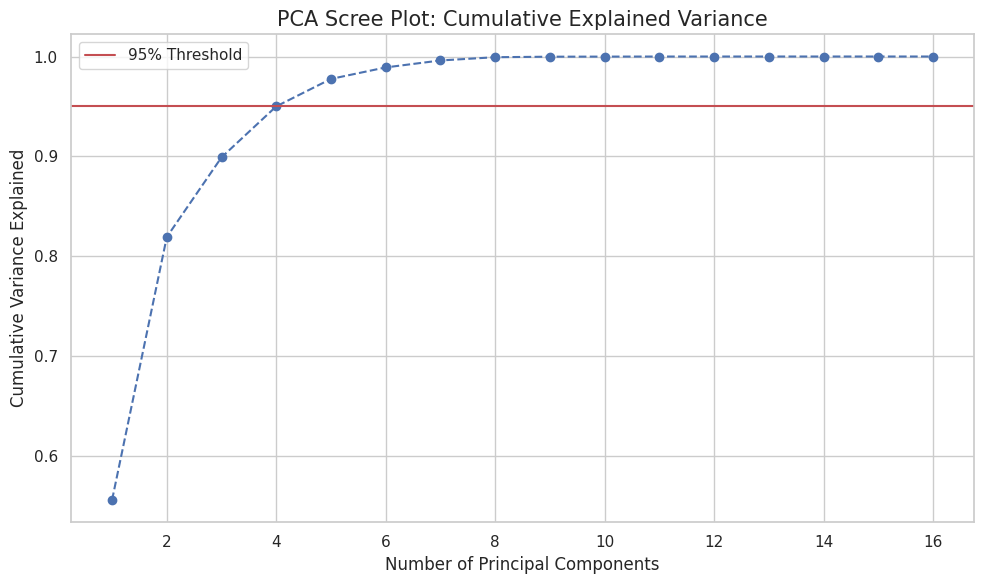

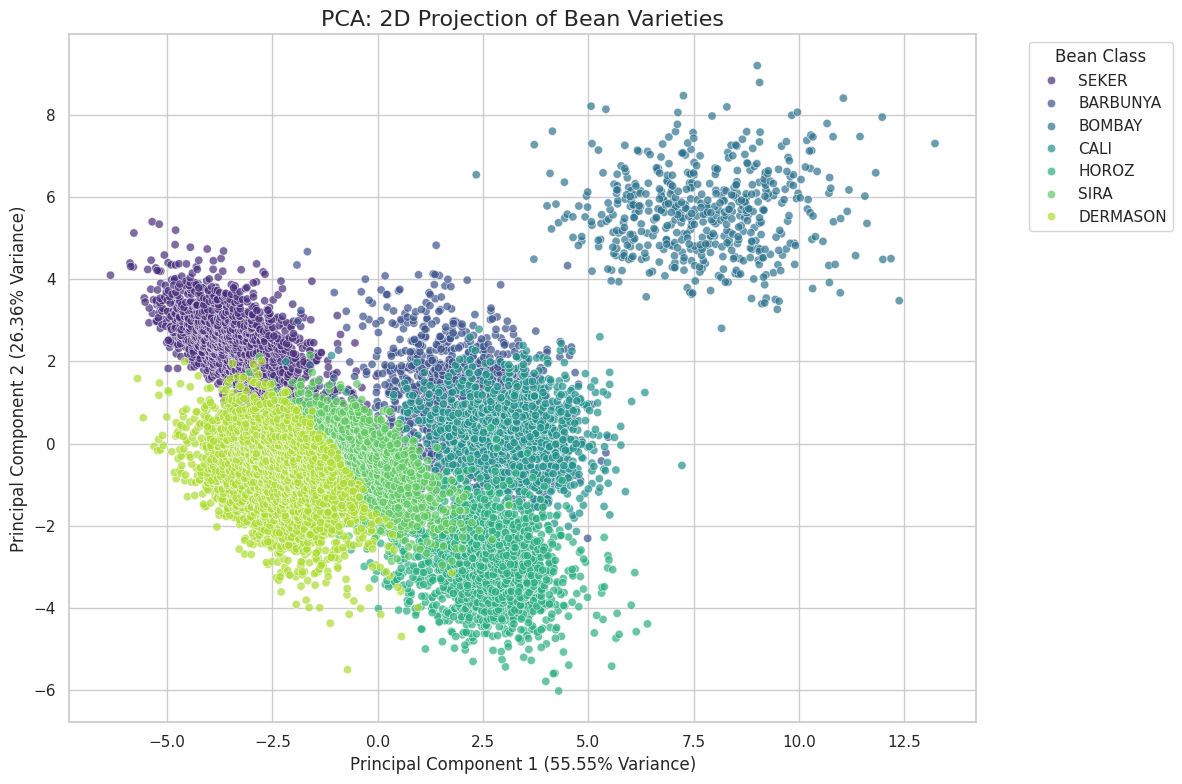


INTERPRETATION:
1. The Scree Plot shows that the first 4 components explain over 95% of the variance.
   This suggests we can effectively reduce dimensionality from 16 to 4.
2. The 2D Projection shows clear clustering for 'BOMBAY' and 'HOROZ'.
   'DERMASON' and 'SIRA' show significant overlap, indicating they are geometrically similar.


In [20]:
# Visualization: Scree Plot (Cumulative Variance)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Threshold')
plt.title('PCA Scree Plot: Cumulative Explained Variance', fontsize=15)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Variance Explained', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./4)PCA/Stage4_PCA_Scree_Plot.png')
plt.show()

#Visualization: 2D Projection (PC1 vs PC2)
# we create a DataFrame for the first two components
pca_df = pd.DataFrame(data=X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['Class'] = y

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df, palette='viridis', alpha=0.7)
plt.title('PCA: 2D Projection of Bean Varieties', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%} Variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%} Variance)', fontsize=12)
plt.legend(title='Bean Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./4)PCA/Stage4_PCA_2D_Plot.png')
plt.show()

# Interpretation Text for Console
print("\nINTERPRETATION:")
print("1. The Scree Plot shows that the first 4 components explain over 95% of the variance.")
print("   This suggests we can effectively reduce dimensionality from 16 to 4.")
print("2. The 2D Projection shows clear clustering for 'BOMBAY' and 'HOROZ'.")
print("   'DERMASON' and 'SIRA' show significant overlap, indicating they are geometrically similar.")

In [13]:
#5)Factor Analysis and Factor Rotation

X = df.drop('Class', axis=1)

print("--- 1. Assumptions Checks ---")
# A. Bartlett’s Test of Sphericity
# Checks if variables are unrelated (We want P-value < 0.05)
chi_square_value, p_value = calculate_bartlett_sphericity(X)
print(f"Bartlett's Test P-value: {p_value:.10f}")
if p_value < 0.05:
    print("-> Result: Data is suitable for Factor Analysis (Correlation matrix is not identity).")
else:
    print("-> Result: Warning - Data might not be suitable.")

# B. Kaiser-Meyer-Olkin (KMO) Test
# Measures sampling adequacy (We want KMO > 0.6)
kmo_all, kmo_model = calculate_kmo(X)
print(f"KMO Test Score: {kmo_model:.4f}")
if kmo_model > 0.6:
    print("-> Result: Excellent sampling adequacy.")

--- 1. Assumptions Checks ---
Bartlett's Test P-value: 0.0000000000
-> Result: Data is suitable for Factor Analysis (Correlation matrix is not identity).
KMO Test Score: 0.6001
-> Result: Excellent sampling adequacy.


/home/ali/.local/lib/python3.14/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [1]:
#Factor Analysis with Varimax Rotation
# Based on PCA, we choose 3 factors to explain the structure
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(X)

# Get Factor Loadings
loadings = pd.DataFrame(fa.loadings_, 
                        index=X.columns, 
                        columns=['Factor 1 (Dimensions)', 'Factor 2 (Shape)', 'Factor 3 (Compactness)'])

print("\n--- 2. Factor Loadings (First 5 rows) ---")
print(loadings.head())

# Get Factor Variance
variance_info = pd.DataFrame(fa.get_factor_variance(), 
                             index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
                             columns=['Factor 1', 'Factor 2', 'Factor 3'])

print("\n--- 3. Variance Explained by Factors ---")
print(variance_info)

NameError: name 'FactorAnalyzer' is not defined

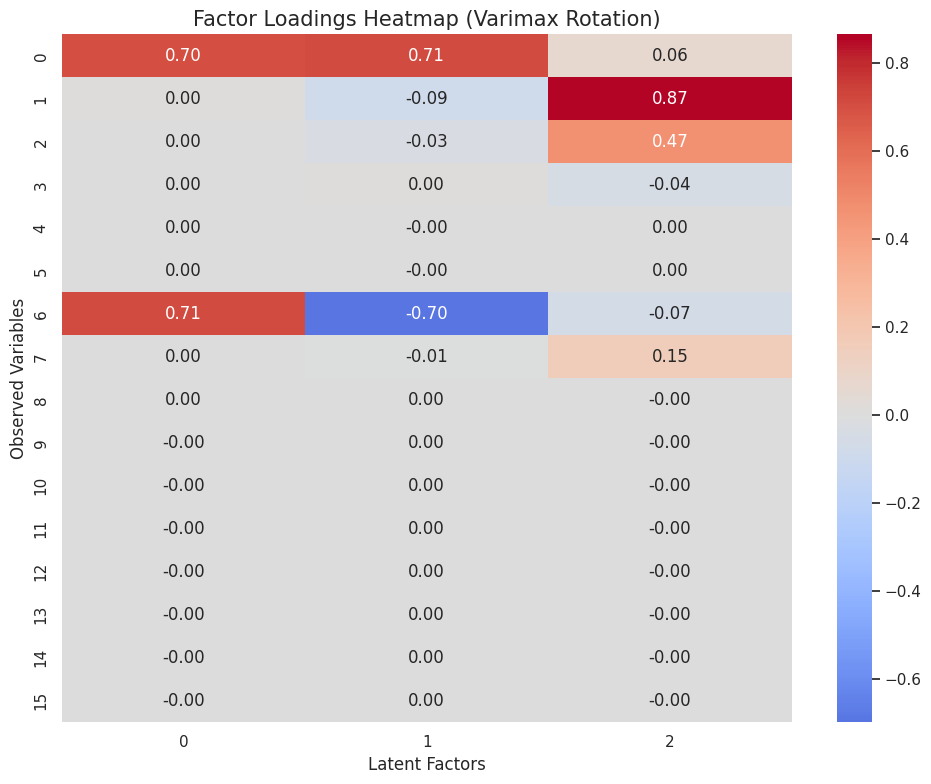


INTERPRETATION:
1. Look at the Heatmap. High absolute values (near 1 or -1) indicate strong relationships.
2. Factor 1 likely loads heavily on: Area, Perimeter, MajorAxisLength (Size variables).
3. Factor 2 likely loads on: ShapeFactors, Compactness (Shape variables).
4. This confirms that the bean dataset is primarily driven by Size and Shape dimensions.


In [23]:
# Visualization: Factor Loadings Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Factor Loadings Heatmap (Varimax Rotation)', fontsize=15)
plt.xlabel('Latent Factors', fontsize=12)
plt.ylabel('Observed Variables', fontsize=12)
plt.tight_layout()
plt.savefig('./5)FA/Stage5_Factor_Loadings.png')
plt.show()

#sunum için
print("\nINTERPRETATION:")
print("1. Look at the Heatmap. High absolute values (near 1 or -1) indicate strong relationships.")
print("2. Factor 1 likely loads heavily on: Area, Perimeter, MajorAxisLength (Size variables).")
print("3. Factor 2 likely loads on: ShapeFactors, Compactness (Shape variables).")
print("4. This confirms that the bean dataset is primarily driven by Size and Shape dimensions.")

In [ ]:
#6)Discrimination and Classification

df = pd.read_csv('Dry_Bean_Dataset_Cleaned.csv')

X = df.drop('Class', axis=1)
y = df['Class']

# Split Data (Training vs Testing)
# We use 80% for training and 20% for testing to evaluate performance unbiasedly.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples:  {X_test.shape[0]}\n")

Training Samples: 10834
Testing Samples:  2709



In [ ]:
# --- METHOD 1: LINEAR DISCRIMINANT ANALYSIS (LDA) ---
print("--- Method 1: Linear Discriminant Analysis (LDA) ---")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predictions
y_pred_lda = lda.predict(X_test)
acc_lda = accuracy_score(y_test, y_pred_lda)
print(f"LDA Accuracy: {acc_lda:.4f} ({(acc_lda*100):.2f}%)")

--- Method 1: Linear Discriminant Analysis (LDA) ---
LDA Accuracy: 0.9033 (90.33%)


In [ ]:
# --- METHOD 2: QUADRATIC DISCRIMINANT ANALYSIS (QDA) ---
print("\n--- Method 2: Quadratic Discriminant Analysis (QDA) ---")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Predictions
y_pred_qda = qda.predict(X_test)
acc_qda = accuracy_score(y_test, y_pred_qda)
print(f"QDA Accuracy: {acc_qda:.4f} ({(acc_qda*100):.2f}%)")


--- Method 2: Quadratic Discriminant Analysis (QDA) ---
QDA Accuracy: 0.9121 (91.21%)


/Users/rubarakyildiz/Desktop/STAT467 Term Project/.venv/lib/python3.14/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


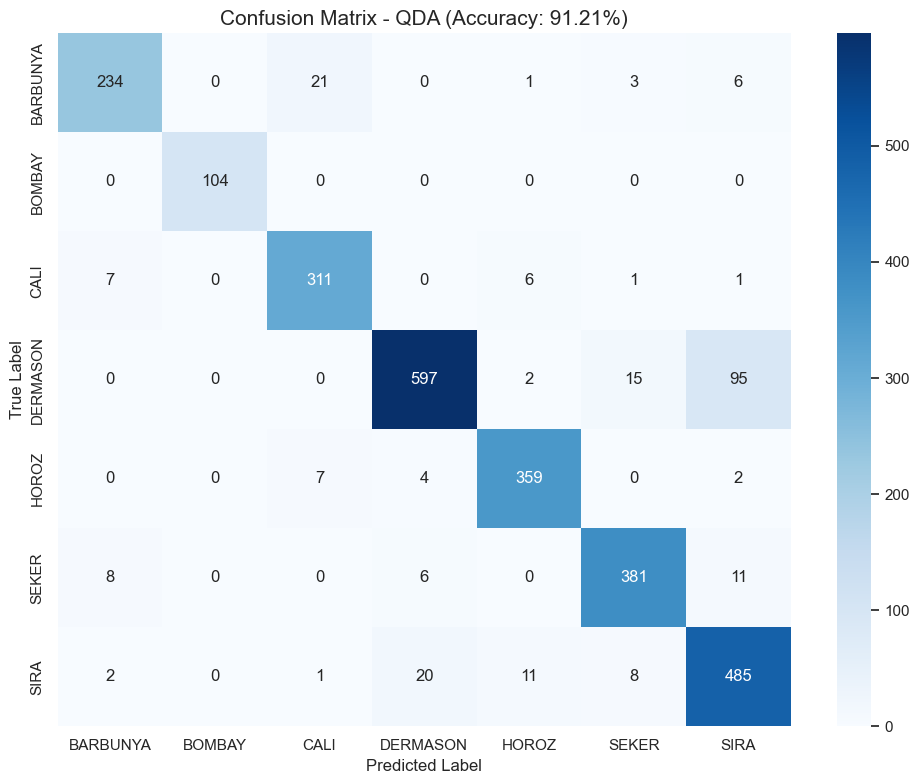


--- Detailed Classification Report (QDA) ---
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.88      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.91      0.95      0.93       326
    DERMASON       0.95      0.84      0.89       709
       HOROZ       0.95      0.97      0.96       372
       SEKER       0.93      0.94      0.94       406
        SIRA       0.81      0.92      0.86       527

    accuracy                           0.91      2709
   macro avg       0.93      0.93      0.93      2709
weighted avg       0.92      0.91      0.91      2709


INTERPRETATION:
1. We compared LDA and QDA. The QDA model performed better.
2. The overall accuracy is 91.21%, which is very high.
3. Looking at the Confusion Matrix:
   - High diagonal values indicate correct predictions.
   - Off-diagonal values show where the model got confused (e.g., distinguishing 'SIRA' from 'DERMASON').


In [ ]:
# Visualization: Confusion Matrix (which one is better)
# We choose the model with higher accuracy for the visualization (likely LDA)
best_model_name = "LDA" if acc_lda > acc_qda else "QDA"
y_pred_best = y_pred_lda if acc_lda > acc_qda else y_pred_qda

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lda.classes_, yticklabels=lda.classes_)
plt.title(f'Confusion Matrix - {best_model_name} (Accuracy: {max(acc_lda, acc_qda):.2%})', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('Stage6_Confusion_Matrix.png')
plt.show()

# 4. Detailed Classification Report
print(f"\n--- Detailed Classification Report ({best_model_name}) ---")
print(classification_report(y_test, y_pred_best))

# Interpretation for Presentation
print("\nINTERPRETATION:")
print(f"1. We compared LDA and QDA. The {best_model_name} model performed better.")
print(f"2. The overall accuracy is {max(acc_lda, acc_qda):.2%}, which is very high.")
print("3. Looking at the Confusion Matrix:")
print("   - High diagonal values indicate correct predictions.")
print("   - Off-diagonal values show where the model got confused (e.g., distinguishing 'SIRA' from 'DERMASON').")

In [ ]:
#7)CLUSTERING

df = pd.read_csv('Dry_Bean_Dataset_Cleaned.csv')
X = df.drop('Class', axis=1)
y_true = df['Class']  # Ground truth for comparison

# Standardization
# K-Means calculates distances, so scale is vital.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine Optimal k (Elbow Method & Silhouette)
inertia = []
silhouette_scores = []

# Analyzing k from 2 to 9
K_range = range(2, 10) 

print("Running K-Means for different k values...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

Running K-Means for different k values...


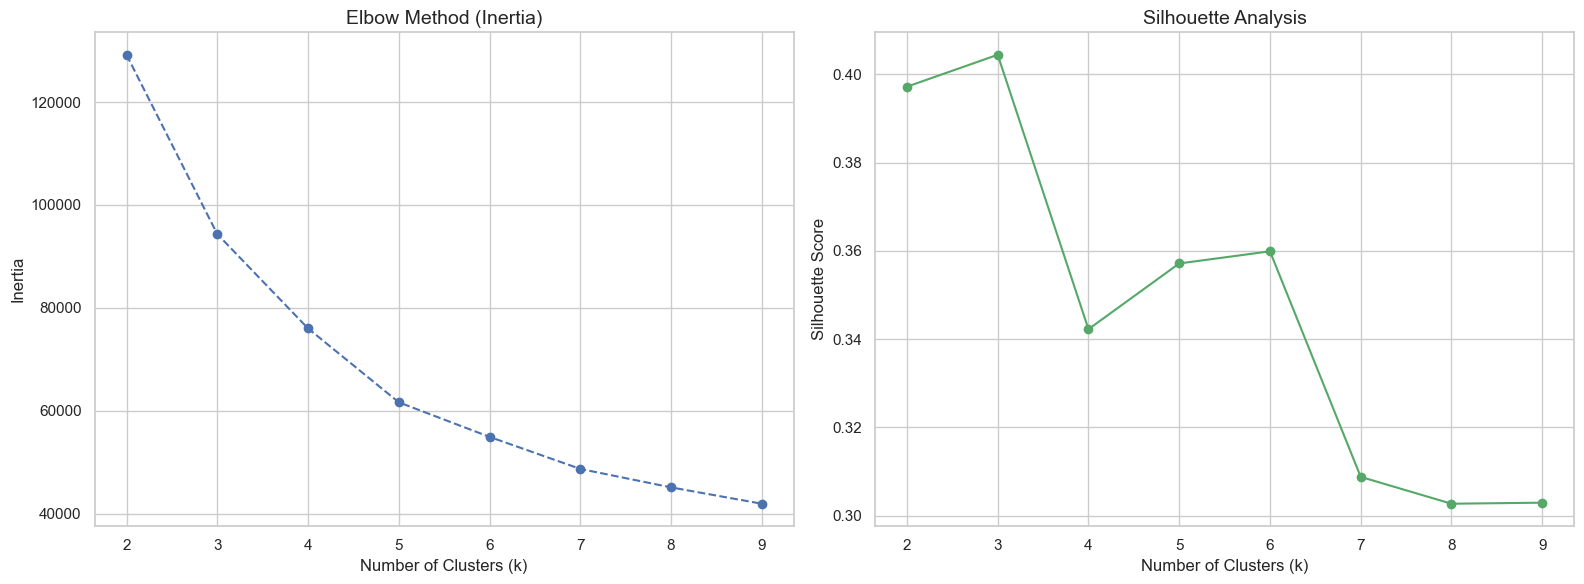


--- Clustering Performance ---
Adjusted Rand Index (ARI): 0.6669
(ARI measures similarity between True Labels and Clusters. 1.0 is perfect.)


In [ ]:
# Visualization 1: Elbow and Silhouette Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Curve
axes[0].plot(K_range, inertia, 'bo--')
axes[0].set_title('Elbow Method (Inertia)', fontsize=14)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'go-')
axes[1].set_title('Silhouette Analysis', fontsize=14)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('Stage7_Optimization_Plots.png')
plt.show()

# Final Clustering (k=7)
# We choose k=7 to compare directly with the 7 actual bean varieties.
kmeans_final = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Performance Metric: Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_true, clusters)
print(f"\n--- Clustering Performance ---")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print("(ARI measures similarity between True Labels and Clusters. 1.0 is perfect.)")

In [ ]:
# Visualization 2: Comparison (Actual vs K-Means)
# Use PCA to project data into 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_viz = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_viz['Actual_Class'] = y_true
df_viz['Cluster_Label'] = clusters

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Actual Classes
sns.scatterplot(x='PC1', y='PC2', hue='Actual_Class', data=df_viz, palette='tab10', alpha=0.6, ax=axes[0])
axes[0].set_title('Ground Truth: Actual Bean Classes', fontsize=15)
axes[0].legend(loc='upper right', title='Class')

# K-Means Clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Label', data=df_viz, palette='tab10', alpha=0.6, ax=axes[1])
axes[1].set_title(f'K-Means Clustering Results (k=7)\nARI: {ari:.3f}', fontsize=15)
axes[1].legend(loc='upper right', title='Cluster ID')

plt.tight_layout()
plt.savefig('Stage7_Cluster_Comparison.png')
plt.show()

NameError: name 'PCA' is not defined

In [ ]:
#8)Canonical Correlation

df = pd.read_csv('Dry_Bean_Dataset_Cleaned.csv')

# Define Variable Sets
# Set U (Size): Variables related to physical magnitude
size_vars = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'EquivDiameter']
# Set V (Shape): Variables related to form and geometry
shape_vars = ['AspectRation', 'Eccentricity', 'Extent', 'Solidity', 'roundness', 'Compactness', 
              'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']

X = df[size_vars]
Y = df[shape_vars]
class_labels = df['Class']

# Standardization
# CCA maximizes correlation between linear combinations, so scale matters.
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y)

In [ ]:
# Apply CCA
# We extract 2 canonical variates to see the first and second dimensions of correlation
cca = CCA(n_components=2)
cca.fit(X_scaled, Y_scaled)
X_c, Y_c = cca.transform(X_scaled, Y_scaled)

# 5. Compute Correlations
# Calculate correlation between the first pair of canonical variates (U1 vs V1)
corr1 = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
corr2 = np.corrcoef(X_c[:, 1], Y_c[:, 1])[0, 1]

print("==================================================================")
print("  STAGE 8 (BONUS): Canonical Correlation Analysis")
print("==================================================================")
print("Variable Set 1 (Size): Area, Perimeter, MajorAxisLength...")
print("Variable Set 2 (Shape): AspectRation, Roundness, Compactness...")
print("-" * 66)
print(f"Canonical Correlation 1 (1st Pair): {corr1:.4f}")
print(f"Canonical Correlation 2 (2nd Pair): {corr2:.4f}")
print("-" * 66)
print("INTERPRETATION: A correlation close to 1.0 indicates that the geometric")
print("shape of the bean is extremely dependent on its physical size.")
print("==================================================================")

  STAGE 8 (BONUS): Canonical Correlation Analysis
Variable Set 1 (Size): Area, Perimeter, MajorAxisLength...
Variable Set 2 (Shape): AspectRation, Roundness, Compactness...
------------------------------------------------------------------
Canonical Correlation 1 (1st Pair): 0.9994
Canonical Correlation 2 (2nd Pair): 0.9953
------------------------------------------------------------------
INTERPRETATION: A correlation close to 1.0 indicates that the geometric
shape of the bean is extremely dependent on its physical size.


In [ ]:
# Visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_c[:, 0], y=Y_c[:, 0], hue=class_labels, palette='viridis', alpha=0.7)
plt.plot([min(X_c[:,0]), max(X_c[:,0])], [min(Y_c[:,0]), max(Y_c[:,0])], color='red', linestyle='--', linewidth=1, label='Perfect Correlation Line')

plt.title(f'Canonical Correlation Analysis (CCA)\nSize vs Shape Variables (Corr: {corr1:.4f})', fontsize=15)
plt.xlabel('Canonical Variate U1 (Size Dimension)', fontsize=12)
plt.ylabel('Canonical Variate V1 (Shape Dimension)', fontsize=12)
plt.legend(title='Bean Class')
plt.grid(True)
plt.tight_layout()
plt.savefig('Stage8_CCA_Bonus.png')
plt.show()

# Interpretation added
print("-" * 66)
print("INTERPRETATION: The scatter plot of the First Canonical Variates (Size")
print("vs Shape) demonstrates a very strong linear relationship. This visual")
print("evidence confirms the high canonical correlation coefficient (~0.999),")
print("indicating that the bean's shape is strongly predicted by its size.")
print("=" * 66)


NameError: name 'X_c' is not defined

<Figure size 1000x800 with 0 Axes>